# LINK TO PRETRAINED MODEL:
./best_model_state.bin

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [93]:
!pip install -qq transformers

In [94]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

from textblob import TextBlob

import re

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import os
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

Setting the device that we will use for our Notebook No need to specify if using colab in GPU runtime type.

In [98]:
url = 'https://raw.githubusercontent.com/aayush9753/MyProjects/main/Sentimental_Analysis_on_MovieReviews/Dataset/sentimental_analysis_on_movie_review.csv'
df_data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe
df_data.head()

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [124]:
df_data.shape

(64720, 6)

We have about 65k examples. Let's check for missing values:

In [126]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fold_id  64720 non-null  int64 
 1   cv_tag   64720 non-null  object
 2   html_id  64720 non-null  int64 
 3   sent_id  64720 non-null  int64 
 4   text     64720 non-null  object
 5   tag      64720 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.0+ MB


Great, no missing values in the score and review texts! Do we have class imbalance?

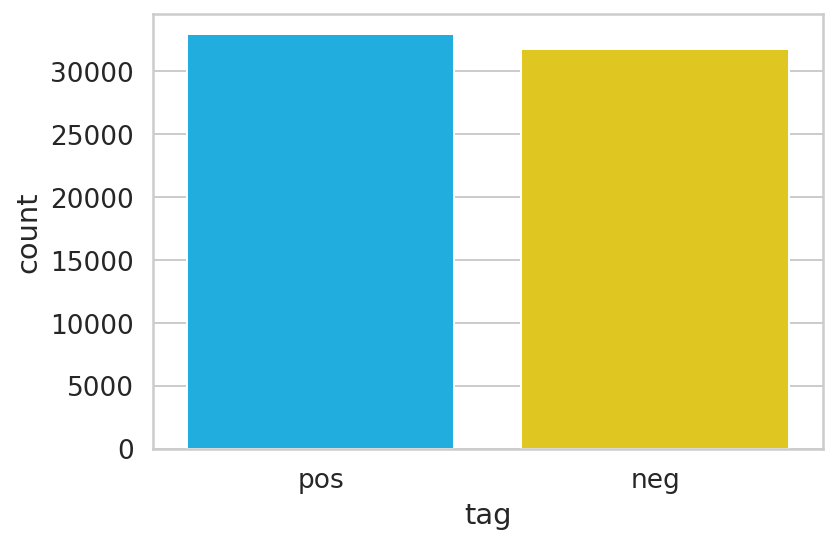

In [130]:
sns.countplot(df_data.tag)
plt.xlabel('tag');

The data is not imbalanced

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [100]:
data = df_data.drop(['fold_id','html_id','sent_id','cv_tag'],axis=1)
data.head()
# data preprocessing
for i in range(data.shape[0]) :
    data['text'][i] = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(#[A-Za-z0-9]+)", " ", data['text'][i]).split()).lower()

In [101]:
data.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,for starters it was created by alan moore and ...,pos
2,to say moore and campbell thoroughly researche...,pos
3,the book or graphic novel if you will is over ...,pos
4,in other words don t dismiss this film because...,pos


ENCODING DATA

In [102]:
emotion_id  = {"pos":1, "neg":0}
data["tag_id"] = data['tag'].map(emotion_id)

In [103]:
data.head()

,text,tag,tag_id
0,films adapted from comic books have had plenty...,pos,1
1,for starters it was created by alan moore and ...,pos,1
2,to say moore and campbell thoroughly researche...,pos,1
3,the book or graphic novel if you will is over ...,pos,1
4,in other words don t dismiss this film because...,pos,1


> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

In [6]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   TFAutoModelForSequenceClassification,
   AdamW,
   glue_convert_examples_to_features
)
import tensorflow as tf
import tensorflow_datasets as tfds
import json

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Initialise tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Choosing Sequence Length

In [131]:
token_lens = []
for txt in data.text:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

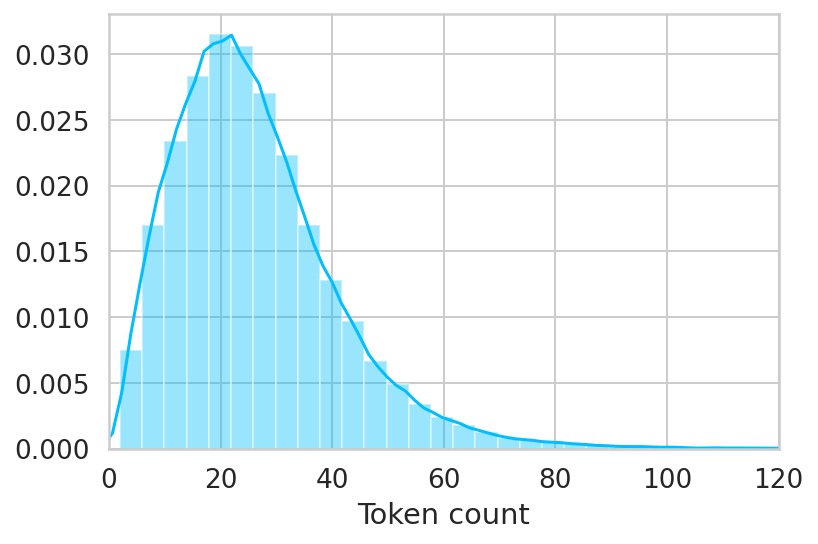

In [132]:
sns.distplot(token_lens)
plt.xlim([0, 120]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 90 tokens, but we'll be on the safe side and choose a maximum length of 100.

In [8]:
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [9]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )


    return {
      'text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [10]:
df = data.copy().drop('tag',axis=1)
df.head()

,text,tag_id
0,films adapted from comic books have had plenty...,1
1,for starters it was created by alan moore and ...,1
2,to say moore and campbell thoroughly researche...,1
3,the book or graphic novel if you will is over ...,1
4,in other words don t dismiss this film because...,1


We have assigned RANDPM_SEED earlier and its = 42

In [11]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [134]:
df_train.shape, df_val.shape, df_test.shape

((58248, 2), (3236, 2), (3236, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [12]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.tag_id.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [13]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [14]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [15]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [16]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [24]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [135]:
last_hidden_state.shape

torch.Size([1, 100, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [136]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [137]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [27]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [28]:
num_classes = 2
model = SentimentClassifier(num_classes)
model = model.to(device)

# Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [30]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [31]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [33]:
# %%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6133870541869334 accuracy 0.655936684521357
Val   loss 0.5413758279067542 accuracy 0.7286773794808404

Epoch 2/10
----------
Train loss 0.42970927158793687 accuracy 0.8033923911550612
Val   loss 0.6430869414815175 accuracy 0.7274412855377008

Epoch 3/10
----------
Train loss 0.27831514119136075 accuracy 0.8915327564894933
Val   loss 0.8770845159888268 accuracy 0.7262051915945611

Epoch 4/10
----------
Train loss 0.20379263872843897 accuracy 0.9331994231561599
Val   loss 1.1476114670668036 accuracy 0.730222496909765

Epoch 5/10
----------
Train loss 0.1617987187998382 accuracy 0.9535434693036672
Val   loss 1.395616840617043 accuracy 0.7212608158220024

Epoch 6/10
----------
Train loss 0.1232765223674668 accuracy 0.967672709792611
Val   loss 1.7033112190406898 accuracy 0.7178615574783683

Epoch 7/10
----------
Train loss 0.09833561515486845 accuracy 0.9745570663370416
Val   loss 1.7794449044680545 accuracy 0.7333127317676142

Epoch 8/10
----------
Train

Note that we’re storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

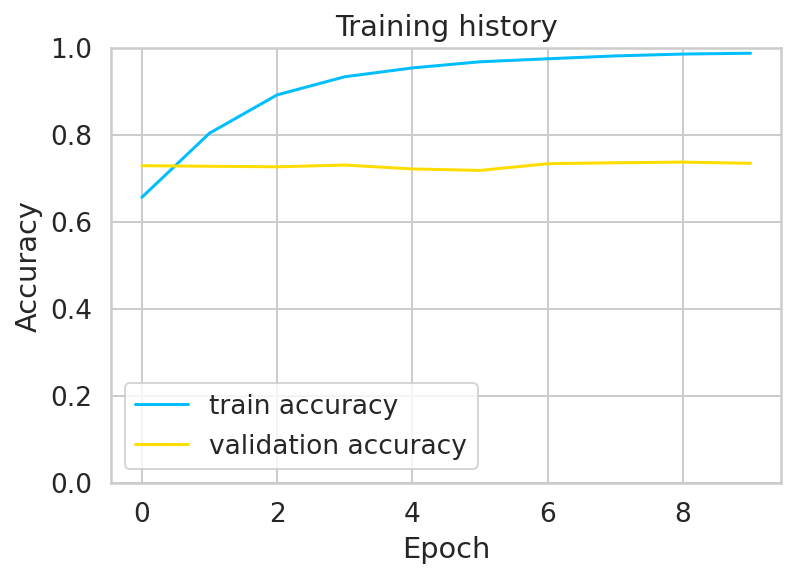

In [35]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

## EVALUATION

So how good is our model on predicting sentiment? Let’s start by calculating the accuracy on the test data:

In [64]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.734548825710754

The accuracy is about equal on the test set. Our model seems to generalize well.

We’ll define a helper function to get the predictions from our model:

In [65]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities:

In [66]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let’s have a look at the classification report

In [72]:

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         neg       0.74      0.72      0.73      1610
         pos       0.73      0.75      0.74      1626

    accuracy                           0.73      3236
   macro avg       0.73      0.73      0.73      3236
weighted avg       0.73      0.73      0.73      3236



We’ll continue with the confusion matrix:

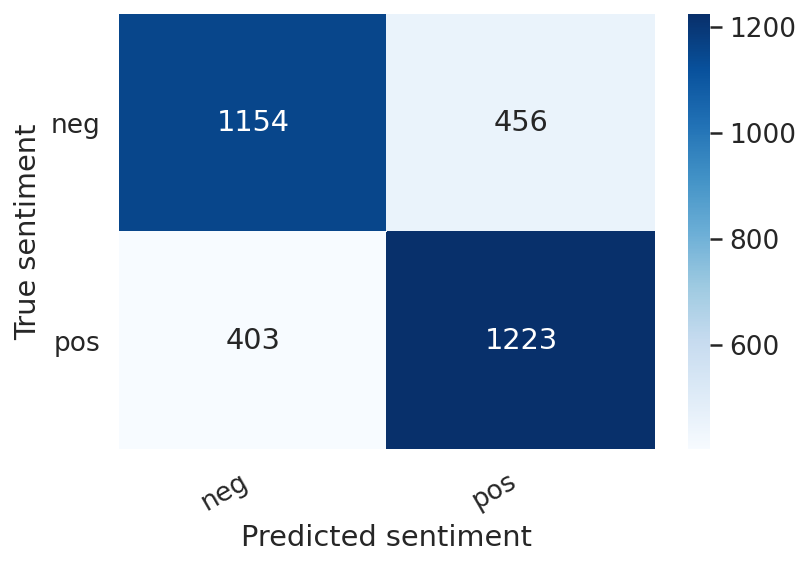

In [106]:
class_names = ['neg','pos']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That’s a good overview of the performance of our model. But let’s have a look at an example from our test data:

In [120]:
idx = -1
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

the movie offers only two explanations neither of which make a lick of
sense

True sentiment: neg


## Predicting on Raw Text
Let’s use our model to predict the sentiment of some raw text:

In [121]:
review_text = "I loved the action"

We have to use the tokenizer to encode the text:

In [122]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let’s get the predictions from our model:

In [123]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I loved the action
Sentiment  : pos


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)